
# Multilabel classification

This example simulates a multi-label document classification problem. The
dataset is generated randomly based on the following process:

    - pick the number of labels: n ~ Poisson(n_labels)
    - n times, choose a class c: c ~ Multinomial(theta)
    - pick the document length: k ~ Poisson(length)
    - k times, choose a word: w ~ Multinomial(theta_c)

In the above process, rejection sampling is used to make sure that n is more
than 2, and that the document length is never zero. Likewise, we reject classes
which have already been chosen.  The documents that are assigned to both
classes are plotted surrounded by two colored circles.

The classification is performed by projecting to the first two principal
components found by PCA and CCA for visualisation purposes, followed by using
the :class:`~sklearn.multiclass.OneVsRestClassifier` metaclassifier using two
SVCs with linear kernels to learn a discriminative model for each class.
Note that PCA is used to perform an unsupervised dimensionality reduction,
while CCA is used to perform a supervised one.

Note: in the plot, "unlabeled samples" does not mean that we don't know the
labels (as in semi-supervised learning) but that the samples simply do *not*
have a label.


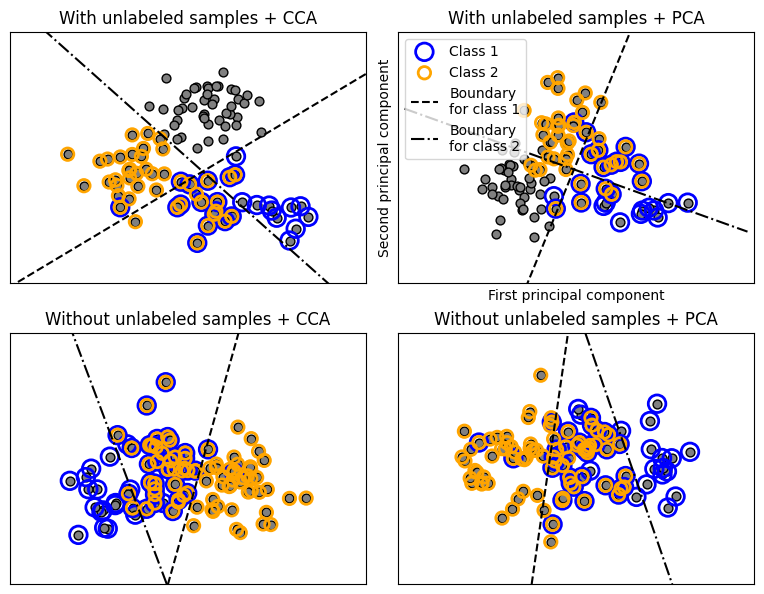

In [1]:
# Authors: Vlad Niculae, Mathieu Blondel
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cross_decomposition import CCA
from sklearn.datasets import make_multilabel_classification
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)


def plot_subfigure(X, Y, subplot, title, transform):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    classif = OneVsRestClassifier(SVC(kernel="linear"))
    classif.fit(X, Y)

    plt.subplot(2, 2, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    plt.scatter(X[:, 0], X[:, 1], s=40, c="gray", edgecolors=(0, 0, 0))
    plt.scatter(
        X[zero_class, 0],
        X[zero_class, 1],
        s=160,
        edgecolors="b",
        facecolors="none",
        linewidths=2,
        label="Class 1",
    )
    plt.scatter(
        X[one_class, 0],
        X[one_class, 1],
        s=80,
        edgecolors="orange",
        facecolors="none",
        linewidths=2,
        label="Class 2",
    )

    plot_hyperplane(
        classif.estimators_[0], min_x, max_x, "k--", "Boundary\nfor class 1"
    )
    plot_hyperplane(
        classif.estimators_[1], min_x, max_x, "k-.", "Boundary\nfor class 2"
    )
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - 0.5 * max_x, max_x + 0.5 * max_x)
    plt.ylim(min_y - 0.5 * max_y, max_y + 0.5 * max_y)
    if subplot == 2:
        plt.xlabel("First principal component")
        plt.ylabel("Second principal component")
        plt.legend(loc="upper left")


plt.figure(figsize=(8, 6))

X, Y = make_multilabel_classification(
    n_classes=2, n_labels=1, allow_unlabeled=True, random_state=1
)

plot_subfigure(X, Y, 1, "With unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 2, "With unlabeled samples + PCA", "pca")

X, Y = make_multilabel_classification(
    n_classes=2, n_labels=1, allow_unlabeled=False, random_state=1
)

plot_subfigure(X, Y, 3, "Without unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 4, "Without unlabeled samples + PCA", "pca")

plt.subplots_adjust(0.04, 0.02, 0.97, 0.94, 0.09, 0.2)
plt.show()